#Downloading the labeled and unlabeled data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
print(os.listdir('/content/drive/MyDrive'))


In [ ]:
# 1. Unzip the zip file into a new folder named data
!unzip "/content/drive/MyDrive/Copy-of-HV-AI-2025.zip" -d "/content/data"



In [ ]:
# List files to confirm your zip is present
import os
print(os.listdir('/content'))

# Unzip with clear file path
!unzip -q /content/HV-AI-2025.zip -d /content/HV-AI-2025

# Check extracted files
print(os.listdir('/content/HV-AI-2025.zip'))

#Downloading the test data

In [ ]:
!unzip Copy-of-HV-AI-2025-Test.zip
!rm -rf /content/__MACOSX
!mv /content/HV-AI-2025-Test/* /content/
!rm -rf /content/HV-AI-2025-Test
!rm /content/HV-AI-2025-Test.zip
!rm -rf /content/sample_data
from google.colab import output
output.clear()

# **Load/Preprocess **data****

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Device and environment checking
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


## Dataset Exploration along with image Directory Validation


In [18]:
#Dataset Exploration
def explore_dataset():
    """Quick exploration of your dataset"""

    # Checking if labels.csv exists and show its structure
    labels_path = '/content/data/HV-AI-2025/labeled_data/labeled_data.csv'
    if os.path.exists(labels_path):
        df = pd.read_csv(labels_path)
        print("Dataset Info:")
        print(f"Total samples: {len(df)}")
        print(f"Columns: {df.columns.tolist()}")
        print("\nFirst few rows:")
        print(df.head())
        print("\nClass distribution:")
        print(df['label'].value_counts())

        # Check for missing values
        print(f"\nMissing values: {df.isnull().sum().sum()}")

        return df
    else:
        print(f"Labels file not found at {labels_path}")
        return None

# Explore dataset
df = explore_dataset()


# Image Directory Validation
def validate_images(df, images_dir):
    if df is None:
        return

    df.columns = df.columns.str.strip()
    image_col = 'img_name'

    print(f"\nValidating images in {images_dir}...")
    missing_images = []
    valid_images = []

    for idx, row in df.iterrows():
        img_path = os.path.join(images_dir, row[image_col])
        if os.path.exists(img_path):
            valid_images.append(img_path)
        else:
            missing_images.append(row[image_col])

    print(f"Valid images: {len(valid_images)}")
    print(f"Missing images: {len(missing_images)}")
    if missing_images:
        print("First few missing images:")
        for img in missing_images[:5]:
            print(f"  - {img}")
    return len(missing_images) == 0


# Validate images
images_dir = '/content/data/HV-AI-2025/labeled_data/images'
images_valid = validate_images(df, images_dir)




Dataset Info:
Total samples: 779
Columns: ['img_name', 'label']

First few rows:
                              img_name label
0  OIP--khXa4p9B3QV8JmsHX29hgHaEK.jpeg  cane
1  OIP--winA9MguCMZn6fdverPlwHaEK.jpeg  cane
2  OIP-0M8AAbNON2zvyCEB2WEhLQHaE8.jpeg  cane
3  OIP-16Mqc38MKBFr4a33cb_dFwHaGO.jpeg  cane
4  OIP-2sIPje3EMq9bP0vV2OGfmwHaEG.jpeg  cane

Class distribution:
label
cane          145
ragno         144
gallina        92
cavallo        78
farfalla       63
mucca          55
scoiattolo     55
pecora         54
gatto          50
elefante       43
Name: count, dtype: int64

Missing values: 0

Validating images in /content/data/HV-AI-2025/labeled_data/images...
Valid images: 779
Missing images: 0


## Visualizing the sample images

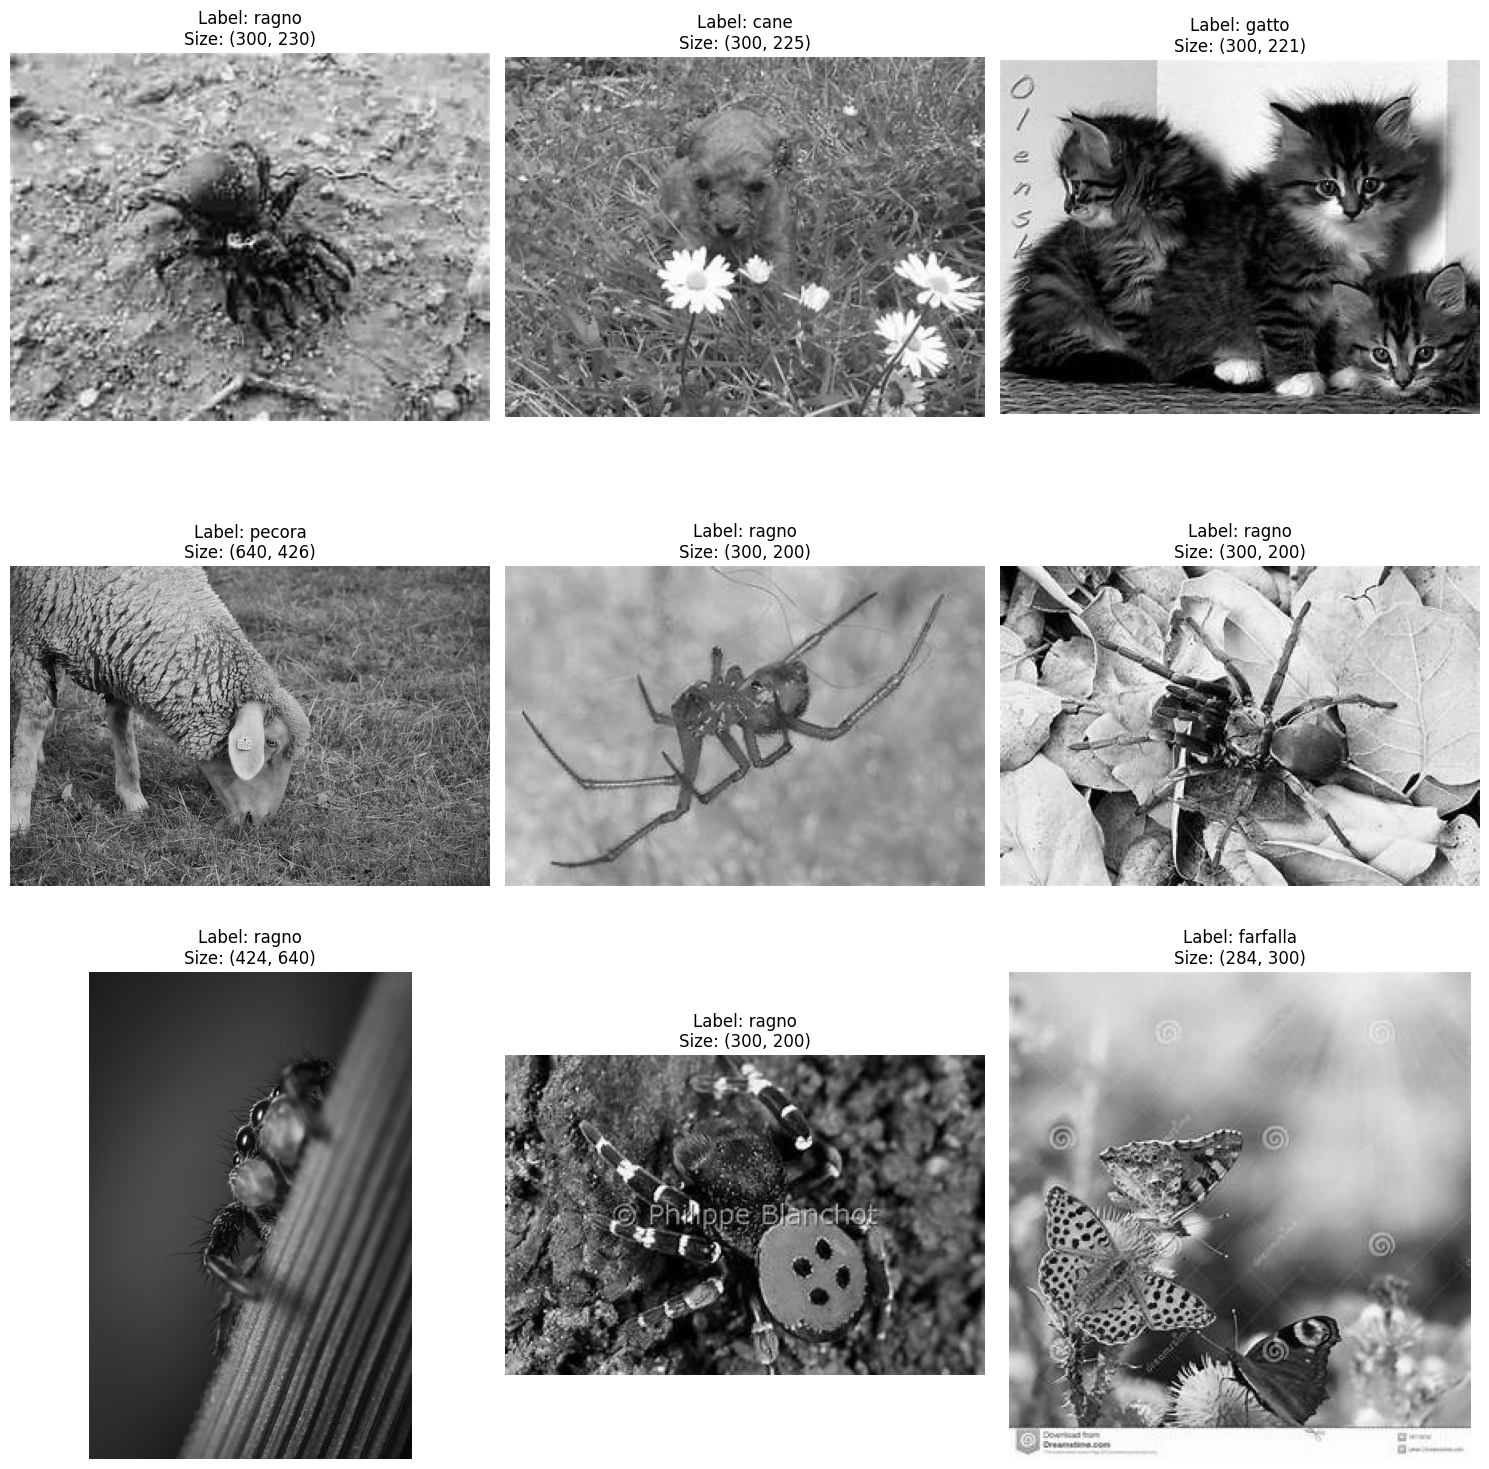

In [19]:

def visualize_samples(df, images_dir, num_samples=9):
    """Visualize random samples from the dataset"""

    if df is None:
        print("No dataset loaded!")
        return

    df.columns = df.columns.str.strip()
    image_col = 'img_name'

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.ravel()

    # Select random sample indices
    sample_indices = np.random.choice(len(df), min(num_samples, len(df)), replace=False)

    for i, idx in enumerate(sample_indices):
        img_path = os.path.join(images_dir, df.iloc[idx][image_col])
        label = df.iloc[idx]['label']

        if os.path.exists(img_path):
            try:
                img = Image.open(img_path).convert('RGB')
                axes[i].imshow(img)
                axes[i].set_title(f'Label: {label}\nSize: {img.size}')
                axes[i].axis('off')
            except Exception as e:
                axes[i].text(0.5, 0.5, f'Error loading image\n{str(e)}',
                             ha='center', va='center', transform=axes[i].transAxes)
                axes[i].set_title(f'Label: {label}')
        else:
            axes[i].text(0.5, 0.5, f'Image not found\n{img_path}',
                         ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'Label: {label}')

    # Hide any remaining blank subplots if less than 9 images
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize samples
if images_valid:
    visualize_samples(df, images_dir)


Analyzing image properties (sample size: 100)...


Analyzing images: 100%|██████████| 100/100 [00:00<00:00, 6767.30it/s]


Image Statistics:
Average width: 312 ± 88
Average height: 246 ± 68
Min dimensions: 170x150
Max dimensions: 640x640
Image formats: {'JPEG': 100}
Color modes: {'L': 100}


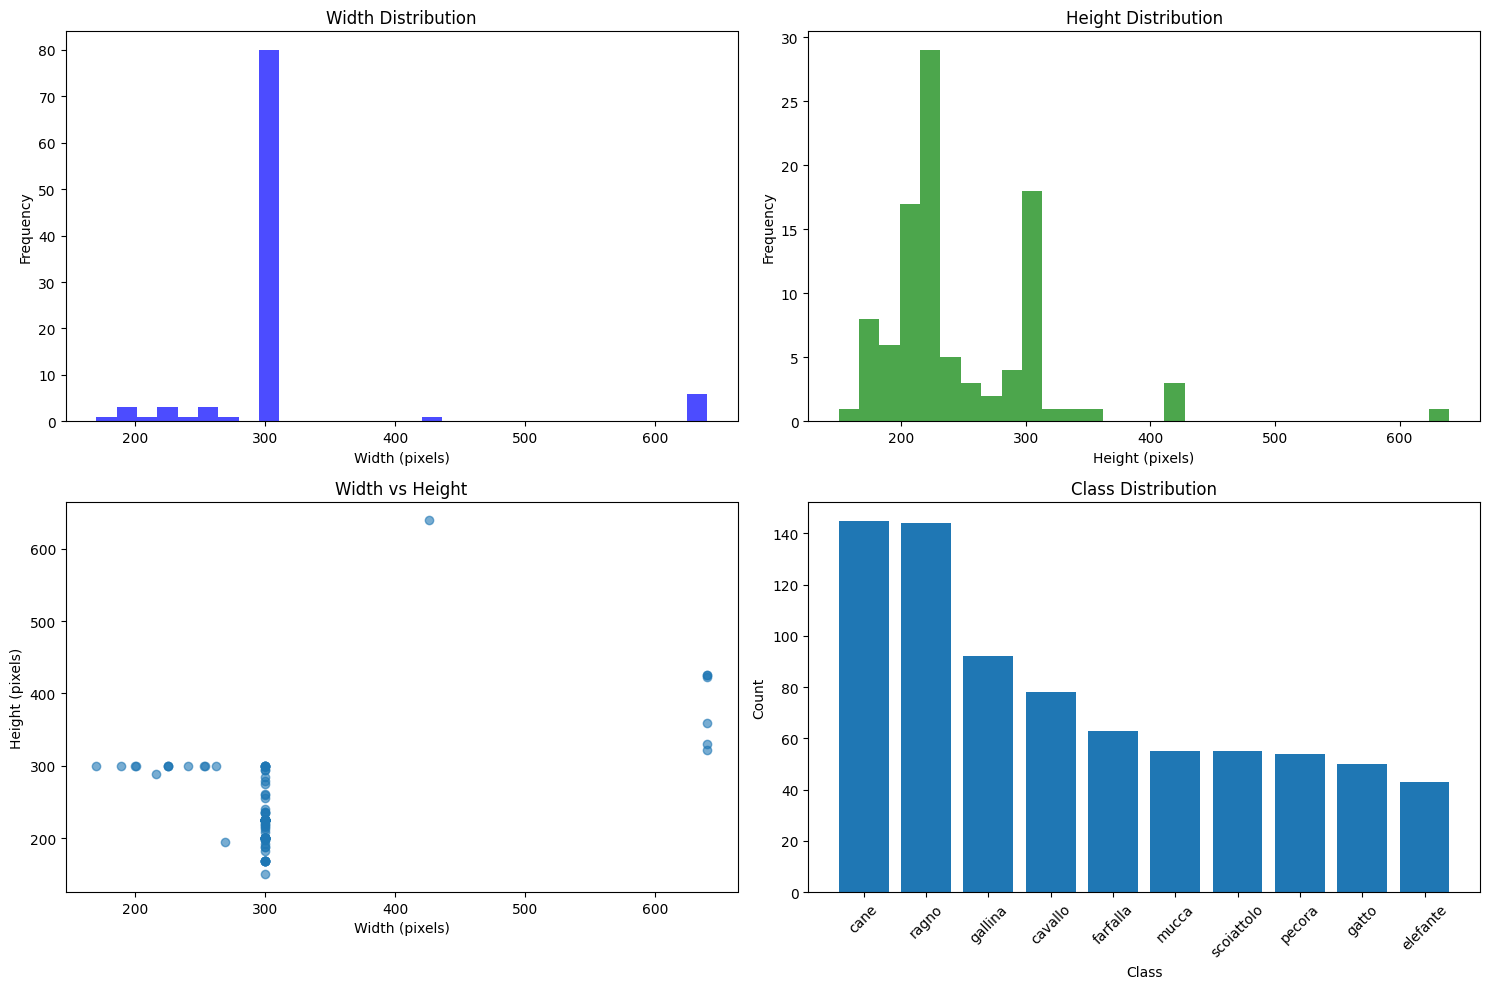

In [20]:
#Analyzing the properties for the iamges that we have.
def analyze_image_properties(df, images_dir, sample_size=100):
    """Analyze image dimensions and properties"""

    if df is None:
        print("No dataset loaded!")
        return
    df.columns = df.columns.str.strip()
    image_col = 'img_name'

    print(f"Analyzing image properties (sample size: {sample_size})...")

    widths, heights = [], []
    formats = {}
    channels = {}

    # Sample random images
    sample_indices = np.random.choice(len(df), min(sample_size, len(df)), replace=False)

    for idx in tqdm(sample_indices, desc="Analyzing images"):
        img_path = os.path.join(images_dir, df.iloc[idx][image_col])

        if os.path.exists(img_path):
            try:
                with Image.open(img_path) as img:
                    widths.append(img.width)
                    heights.append(img.height)
                    formats[img.format] = formats.get(img.format, 0) + 1
                    channels[img.mode] = channels.get(img.mode, 0) + 1
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    if widths:
        print(f"\nImage Statistics:")
        print(f"Average width: {np.mean(widths):.0f} ± {np.std(widths):.0f}")
        print(f"Average height: {np.mean(heights):.0f} ± {np.std(heights):.0f}")
        print(f"Min dimensions: {min(widths)}x{min(heights)}")
        print(f"Max dimensions: {max(widths)}x{max(heights)}")
        print(f"Image formats: {formats}")
        print(f"Color modes: {channels}")

        # Plot dimension distribution
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

        ax1.hist(widths, bins=30, alpha=0.7, color='blue')
        ax1.set_title('Width Distribution')
        ax1.set_xlabel('Width (pixels)')
        ax1.set_ylabel('Frequency')

        ax2.hist(heights, bins=30, alpha=0.7, color='green')
        ax2.set_title('Height Distribution')
        ax2.set_xlabel('Height (pixels)')
        ax2.set_ylabel('Frequency')

        ax3.scatter(widths, heights, alpha=0.6)
        ax3.set_title('Width vs Height')
        ax3.set_xlabel('Width (pixels)')
        ax3.set_ylabel('Height (pixels)')

        # Class distribution
        class_counts = df['label'].value_counts()
        ax4.bar(class_counts.index, class_counts.values)
        ax4.set_title('Class Distribution')
        ax4.set_xlabel('Class')
        ax4.set_ylabel('Count')
        ax4.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

# Analyze image properties
if images_valid:
    analyze_image_properties(df, images_dir)

In [21]:
#Custom image dataset class creation
class ImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.labels_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        # Create label to index mapping
        self.classes = sorted(self.labels_df['label'].unique())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.idx_to_class = {idx: cls for cls, idx in self.class_to_idx.items()}

        print(f"Dataset created with {len(self.classes)} classes: {self.classes}")
        print(f"Total samples: {len(self.labels_df)}")

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        df.columns = df.columns.str.strip()
        image_col = 'img_name'
        img_path = os.path.join(self.root_dir, self.labels_df.iloc[idx][image_col])
        image = Image.open(img_path).convert('RGB')
        label = self.labels_df.iloc[idx]['label']
        label_idx = self.class_to_idx[label]

        if self.transform:
            image = self.transform(image)

        return image, label_idx


## Data Transformation


In [22]:
#Data Transformation function
def get_transforms():
    """Define training and validation transforms"""

    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transforms, val_transforms

# Get transforms
train_transforms, val_transforms = get_transforms()
print("Data transforms created successfully!")

Data transforms created successfully!


## Creating datasets and data loaders


In [24]:
# Configuration
batch_size = 32
num_workers = 2
train_split = 0.8

# File paths
csv_file = '/content/data/HV-AI-2025/labeled_data/labeled_data.csv'
images_dir = '/content/data/HV-AI-2025/labeled_data/images'

if os.path.exists(csv_file) and os.path.exists(images_dir):
    # Create full dataset
    full_dataset = ImageDataset(csv_file, images_dir, transform=train_transforms)

    # Split dataset
    train_size = int(train_split * len(full_dataset))
    val_size = len(full_dataset) - train_size

    # Create train/val splits
    train_dataset, val_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )

    # Apply validation transforms to validation dataset
    val_dataset.dataset.transform = val_transforms

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    print(f"\nDatasets created successfully!")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Batch size: {batch_size}")
    print(f"Number of classes: {len(full_dataset.classes)}")
    print(f"Classes: {full_dataset.classes}")

    # Test data loader
    print("\nTesting data loader...")
    for batch_idx, (images, labels) in enumerate(train_loader):
        print(f"Batch {batch_idx + 1}: Images shape: {images.shape}, Labels shape: {labels.shape}")
        if batch_idx == 0:  # Just test first batch
            break

    print("Data loading and preprocessing completed successfully!")

else:
    print("Error: Dataset files not found!")
    print(f"CSV file exists: {os.path.exists(csv_file)}")
    print(f"Images directory exists: {os.path.exists(images_dir)}")


Dataset created with 10 classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Total samples: 779

Datasets created successfully!
Training samples: 623
Validation samples: 156
Batch size: 32
Number of classes: 10
Classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']

Testing data loader...
Batch 1: Images shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32])
Data loading and preprocessing completed successfully!


## Visualizing the transformed images


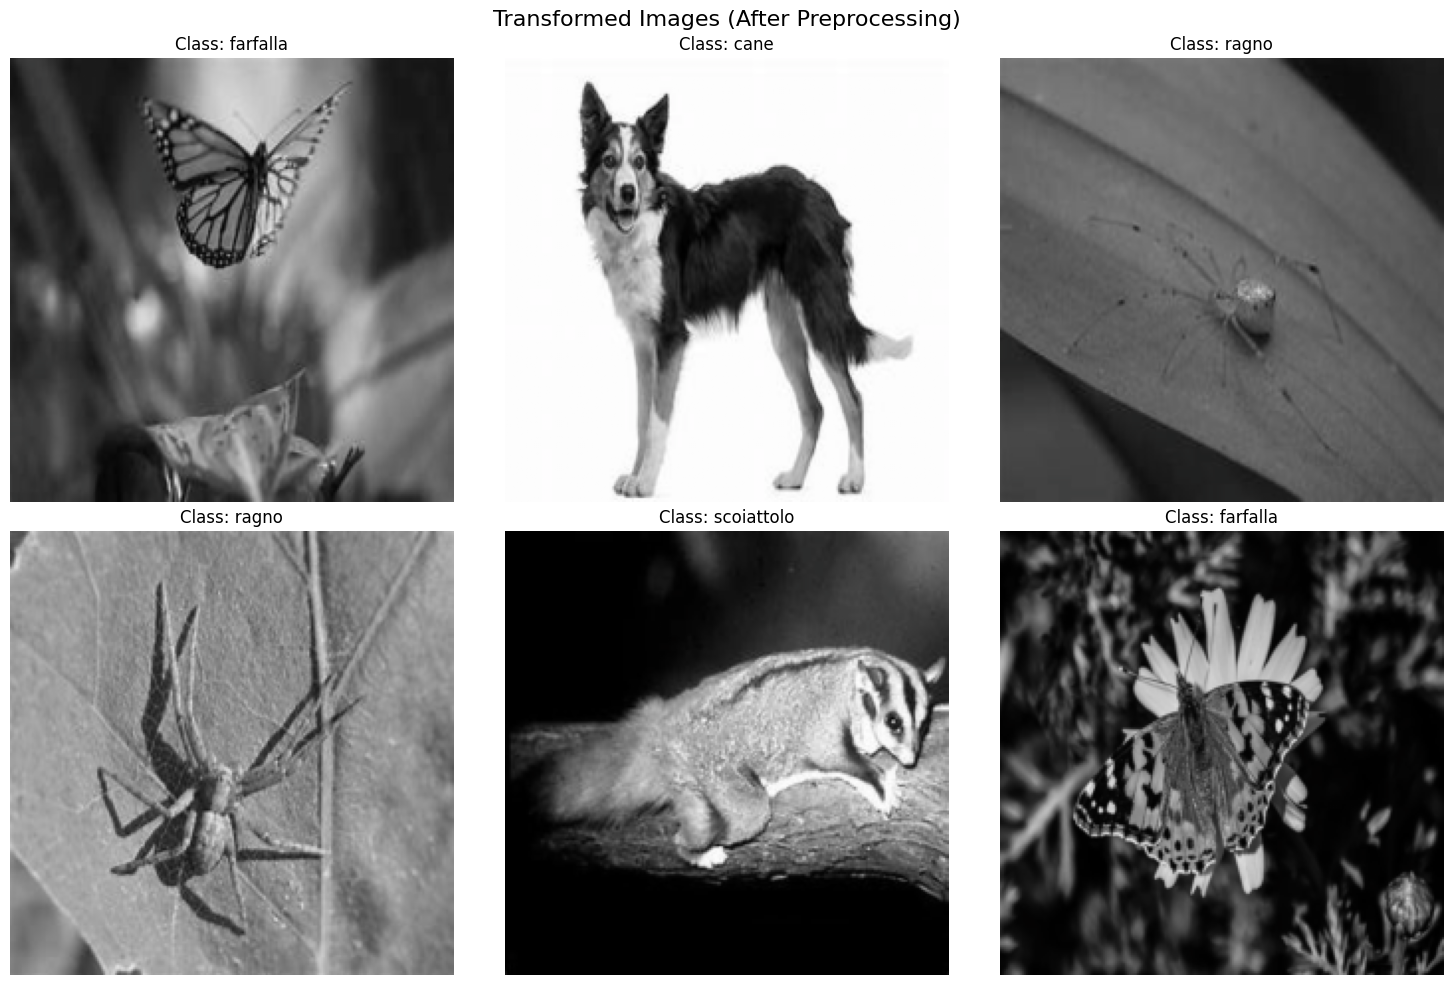

In [25]:
#Visualizing the transformed images
def visualize_transformed_images(dataset, num_samples=6):
    """Visualize how images look after transformations"""

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for i in range(min(num_samples, len(dataset))):
        # Get random sample
        idx = np.random.randint(0, len(dataset))
        image, label = dataset[idx]

        # Convert tensor back to image for visualization
        if isinstance(image, torch.Tensor):
            # Denormalize
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            image = image * std + mean
            image = torch.clamp(image, 0, 1)

            # Convert to numpy
            image = image.permute(1, 2, 0).numpy()

        axes[i].imshow(image)
        axes[i].set_title(f'Class: {full_dataset.classes[label]}')
        axes[i].axis('off')

    plt.suptitle('Transformed Images (After Preprocessing)', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize transformed images
if 'train_dataset' in locals():
    visualize_transformed_images(train_dataset)


# **Model initialization/Training**

## Model Architecture(using ResNet-18)

In [26]:
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(ResNetClassifier, self).__init__()

        # Load pretrained ResNet-18
        self.resnet = models.resnet18(pretrained=pretrained)

        # Replace the final fully connected layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [27]:
#Get number of classes
num_classes = len(full_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Classes: {full_dataset.classes}")

# Initialize model
model = ResNetClassifier(num_classes=num_classes, pretrained=True)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel initialized successfully!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Number of classes: 10
Classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]



Model initialized successfully!
Total parameters: 11,181,642
Trainable parameters: 11,181,642


## Loss Functions and Optimizers


In [28]:
#Loss function(Categorical Cross Entropy and Adaptive Model Optimizer)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
print(f"\nTraining configuration:")
print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")
print(f"Learning rate: {learning_rate}")
print(f"Scheduler: {scheduler}")



Training configuration:
Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Learning rate: 0.001
Scheduler: <torch.optim.lr_scheduler.StepLR object at 0x7d9e58d5d9d0>


## Training functions and their types

In [29]:
# Hyperparameters tuning
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = running_corrects.double() / len(val_loader.dataset)

    return epoch_loss, epoch_acc

In [30]:
# Training configuration
num_epochs = 25
print(f"\nStarting training for {num_epochs} epochs")

# Initialize tracking variables
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0.0
best_model_wts = model.state_dict().copy()

# Training loop
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 40)

    # Training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc.cpu().numpy())

    # Validation phase
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.cpu().numpy())

    # Print epoch results
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = model.state_dict().copy()
        print(f'New best model! Val Acc: {best_val_acc:.4f}')

    # Step scheduler
    scheduler.step()

    # Print current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Learning Rate: {current_lr:.6f}')

# Load best model weights
model.load_state_dict(best_model_wts)
print(f"\nTraining completed!")
print(f"Best validation accuracy: {best_val_acc:.4f}")



Starting training for 25 epochs...

Epoch 1/25
----------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.01it/s]


Train Loss: 1.3248 | Train Acc: 0.5570
Val Loss: 7.0468 | Val Acc: 0.3013
New best model! Val Acc: 0.3013
Learning Rate: 0.001000

Epoch 2/25
----------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.84it/s]


Train Loss: 0.6003 | Train Acc: 0.8202
Val Loss: 1.5982 | Val Acc: 0.5064
New best model! Val Acc: 0.5064
Learning Rate: 0.001000

Epoch 3/25
----------------------------------------


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]


Train Loss: 0.2903 | Train Acc: 0.9197
Val Loss: 1.5275 | Val Acc: 0.5962
New best model! Val Acc: 0.5962
Learning Rate: 0.001000

Epoch 4/25
----------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.93it/s]


Train Loss: 0.1856 | Train Acc: 0.9438
Val Loss: 1.4988 | Val Acc: 0.5897
Learning Rate: 0.001000

Epoch 5/25
----------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.78it/s]


Train Loss: 0.2736 | Train Acc: 0.9117
Val Loss: 2.0381 | Val Acc: 0.5449
Learning Rate: 0.001000

Epoch 6/25
----------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.76it/s]


Train Loss: 0.1749 | Train Acc: 0.9518
Val Loss: 2.1847 | Val Acc: 0.5385
Learning Rate: 0.001000

Epoch 7/25
----------------------------------------


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


Train Loss: 0.1718 | Train Acc: 0.9390
Val Loss: 1.4952 | Val Acc: 0.5769
Learning Rate: 0.000100

Epoch 8/25
----------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.78it/s]


Train Loss: 0.1121 | Train Acc: 0.9663
Val Loss: 1.1430 | Val Acc: 0.6603
New best model! Val Acc: 0.6603
Learning Rate: 0.000100

Epoch 9/25
----------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.95it/s]


Train Loss: 0.0311 | Train Acc: 0.9936
Val Loss: 1.0371 | Val Acc: 0.6795
New best model! Val Acc: 0.6795
Learning Rate: 0.000100

Epoch 10/25
----------------------------------------


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]


Train Loss: 0.0248 | Train Acc: 0.9968
Val Loss: 0.9322 | Val Acc: 0.7179
New best model! Val Acc: 0.7179
Learning Rate: 0.000100

Epoch 11/25
----------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.82it/s]


Train Loss: 0.0263 | Train Acc: 0.9984
Val Loss: 0.9959 | Val Acc: 0.6923
Learning Rate: 0.000100

Epoch 12/25
----------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.91it/s]


Train Loss: 0.0081 | Train Acc: 1.0000
Val Loss: 0.9620 | Val Acc: 0.6987
Learning Rate: 0.000100

Epoch 13/25
----------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.85it/s]


Train Loss: 0.0081 | Train Acc: 1.0000
Val Loss: 0.9248 | Val Acc: 0.6987
Learning Rate: 0.000100

Epoch 14/25
----------------------------------------


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.50it/s]


Train Loss: 0.0082 | Train Acc: 1.0000
Val Loss: 0.9121 | Val Acc: 0.7179
Learning Rate: 0.000010

Epoch 15/25
----------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.94it/s]


Train Loss: 0.0094 | Train Acc: 1.0000
Val Loss: 0.9333 | Val Acc: 0.7115
Learning Rate: 0.000010

Epoch 16/25
----------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.06it/s]


Train Loss: 0.0073 | Train Acc: 0.9984
Val Loss: 0.8962 | Val Acc: 0.7308
New best model! Val Acc: 0.7308
Learning Rate: 0.000010

Epoch 17/25
----------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.87it/s]


Train Loss: 0.0055 | Train Acc: 1.0000
Val Loss: 0.9220 | Val Acc: 0.7179
Learning Rate: 0.000010

Epoch 18/25
----------------------------------------


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.96it/s]


Train Loss: 0.0134 | Train Acc: 0.9984
Val Loss: 0.9351 | Val Acc: 0.7051
Learning Rate: 0.000010

Epoch 19/25
----------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.92it/s]


Train Loss: 0.0076 | Train Acc: 1.0000
Val Loss: 0.8827 | Val Acc: 0.7244
Learning Rate: 0.000010

Epoch 20/25
----------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.94it/s]


Train Loss: 0.0061 | Train Acc: 1.0000
Val Loss: 0.9036 | Val Acc: 0.7115
Learning Rate: 0.000010

Epoch 21/25
----------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.86it/s]


Train Loss: 0.0055 | Train Acc: 1.0000
Val Loss: 0.9132 | Val Acc: 0.7051
Learning Rate: 0.000001

Epoch 22/25
----------------------------------------


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.85it/s]


Train Loss: 0.0067 | Train Acc: 1.0000
Val Loss: 0.9040 | Val Acc: 0.7308
Learning Rate: 0.000001

Epoch 23/25
----------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.88it/s]


Train Loss: 0.0078 | Train Acc: 0.9984
Val Loss: 0.9020 | Val Acc: 0.7372
New best model! Val Acc: 0.7372
Learning Rate: 0.000001

Epoch 24/25
----------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.79it/s]


Train Loss: 0.0050 | Train Acc: 1.0000
Val Loss: 0.9092 | Val Acc: 0.7179
Learning Rate: 0.000001

Epoch 25/25
----------------------------------------


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.93it/s]

Train Loss: 0.0058 | Train Acc: 1.0000
Val Loss: 0.9122 | Val Acc: 0.7244
Learning Rate: 0.000001

Training completed!
Best validation accuracy: 0.7372


# **Model Inference**

In [31]:
## Infering the model on the test set
class UnlabeledImageDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        self.images_dir = images_dir
        self.image_files = sorted([f for f in os.listdir(images_dir)
                                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_name


In [32]:
test_images_dir = '/content/drive/MyDrive/HV-AI-2025-Test/test_images'
test_transforms = val_transforms

test_dataset = UnlabeledImageDataset(test_images_dir, transform=test_transforms)

from torch.utils.data import DataLoader

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)


In [33]:
model.eval()
pred_filenames = []
pred_classes = []

with torch.no_grad():
    for images, img_names in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        pred_filenames.extend(img_names)
        pred_classes.extend(preds.cpu().numpy())

class_names = full_dataset.classes
pred_class_names = [class_names[i] for i in pred_classes]


## Saving the results

In [34]:
results_df = pd.DataFrame({
    'img_name': pred_filenames,
    'pred_label': pred_class_names
})

results_df.to_csv('test_predictions.csv', index=False)
print("Predictions have been saved to test_predictions.csv")


Predictions have been saved to test_predictions.csv


# **Helper Functions**

In [ ]:
# import requests

# def send_results_for_evaluation(name, csv_file, email):
#     url = "http://43.205.49.236:5050/inference"
#     files = {'file': open(csv_file, 'rb')}
#     data = {'email': email, 'name':name}
#     response = requests.post(url, files=files, data=data)
#     return response.json()



# ***Test Inference***


This function is used to save the csv file and send it to the evaluation server.

Format of CSV file (Follow the header names strictly):

          path (str)               predicted_label(str)
    test_data/images/xx.jpg               class_1         
    test_data/images/yy.jpg               class_2         
             :                               :                          
             :                               :                          

Once the prediction file is saved as shown in the above format, you can send it to the evaluation server along with your email.

Caution: check your **email** before executing the cell.


In [ ]:

# print('Accuracy: ')
# print(send_results_for_evaluation('Name', 'path_to_predictions.csv', 'email'))


